<a href="https://colab.research.google.com/github/rohan-vr/Natural-Language-Processing/blob/master/Eng_Hin_NMT_custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import all the necessary modules

In [3]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Bidirectional
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
from keras.models import load_model
import pandas as pd
from nltk.translate.bleu_score import corpus_bleu

Using TensorFlow backend.


Now comes the part of loading our cleaned English and Hindi datasets and create tokenizer for English dataset and Hindi dataset and then we find the max length of sentences of English and Hindi. At last we encode sequences to prepare training data and validation data.

In [4]:
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X

# load datasets
dataset = load_clean_sentences('en-hi-both.pkl')
train = load_clean_sentences('en-hi-train.pkl')
test = load_clean_sentences('en-hi-test.pkl')

# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))

# prepare german tokenizer
hin_tokenizer = create_tokenizer(dataset[:, 1])
hin_vocab_size = len(hin_tokenizer.word_index) + 1
hin_length = max_length(dataset[:, 1])
print('Hindi Vocabulary Size: %d' % hin_vocab_size)
print('Hindi Max Length: %d' % (hin_length))

# prepare training data
trainX = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_sequences(hin_tokenizer, hin_length, train[:, 1])

# prepare validation data
testX = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_sequences(hin_tokenizer, hin_length, test[:, 1])

English Vocabulary Size: 12550
English Max Length: 15
Hindi Vocabulary Size: 19645
Hindi Max Length: 17


Now comes the part to define our model. Lets do it!

In [5]:
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	model = Sequential()
	model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
	model.add(Bidirectional(LSTM(units=n_units)))
	model.add(RepeatVector(tar_timesteps))
	model.add(LSTM(n_units, return_sequences=True))
	model.add(Dense(tar_vocab, activation='softmax'))
	return model

model = define_model(eng_vocab_size, hin_vocab_size, eng_length, hin_length, 512)
rms = RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 512)           6425600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1024)              4198400   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 17, 1024)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 17, 512)           3147776   
_________________________________________________________________
dense_1 (Dense)              (None, 17, 19645)         10077885  
Total params: 23,849,661
Trainable params: 23,849,661
Non-trainable params: 0
_________________________________________________________________
None


Now let us save the model. Dont forget to save checkpoints.

In [0]:
filename = 'model.h1.26_april_20'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

Now let us train the model and keep a track of loss and validation loss which will help us to plot these two variables in a graph so we can visualize it easily.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 121500 samples, validate on 13500 samples
Epoch 1/30
121500/121500 [==============================] - 245s 2ms/step - loss: 1.8548 - val_loss: 1.5784

Epoch 00001: val_loss improved from inf to 1.57844, saving model to model.h1.26_april_20
Epoch 2/30
121500/121500 [==============================] - 242s 2ms/step - loss: 1.4691 - val_loss: 1.4007

Epoch 00002: val_loss improved from 1.57844 to 1.40074, saving model to model.h1.26_april_20
Epoch 3/30
121500/121500 [==============================] - 242s 2ms/step - loss: 1.2768 - val_loss: 1.2177

Epoch 00003: val_loss improved from 1.40074 to 1.21773, saving model to model.h1.26_april_20
Epoch 4/30
121500/121500 [==============================] - 241s 2ms/step - loss: 1.0784 - val_loss: 1.0511

Epoch 00004: val_loss improved from 1.21773 to 1.05113, saving model to model.h1.26_april_20
Epoch 5/30
121500/121500 [==============================] - 240s 2ms/step - loss: 0.9209 - val_loss: 0.9377

Epoch 00005: val_loss improved from 

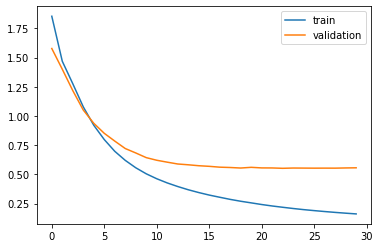

In [7]:
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), epochs=30, batch_size=512, validation_split=0.1, callbacks=[checkpoint],  verbose=1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Okay so now we are done with training. As we can see the graph, that is a pretty smooth curve! Now is the time to test our model. First we will load the model then make predictions over the test dataset we created.

In [8]:
testX=testX[0:50] # lets take 50 sentences of test data set

model = load_model('model.h1.26_april_20')

preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

# a function that is going to grab words.
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], hin_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], hin_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Okay so now time to see predictions. After that we will calculate BLEU scores. BLEU scores are the way to test how your model is performing the tranlsation task. It is calulated by comparing the actual translated text with the predicted translated text.

Note: BLEU score cannot be 1

In [11]:
import pandas as pd
pred_df = pd.DataFrame({'input' : test[0:50,0], 'actual' : test[0:50,1], 'predicted' : preds_text})
pred_df.sample(15)

,input,actual,predicted
30,sensitive,संवेदनशील,संवेदनशील
28,phrase not found,मुहावरा नहीं मिला,मुहावरा नहीं मिला
7,server unexpectedly disconnected,सर्वर अप्रत्याशित रूप से असंबंधित हो गया,सर्वर अप्रत्याशित रूप से असंबंधित
35,in the future,भविष्य में,भविष्य में
34,kde application templates,केडीई अनुप्रयोग टैम्प्लेट्स,केडीई अनुप्रयोग
6,open the specified playlist as an audio project,बतौर ऑडियो परियोजना निर्दिष्ट गीतसूची खोलें,बतौर ऑडियो परियोजना निर्दिष्ट गीतसूची खोलें ...
19,toggle display of sun,सूर्य दिखाना टागल करें,ग्रह दिखाना करें
36,the source of the alignment,संरेखण का स्रोत,संरेखण का स्रोत
32,porn groove,पॉर्न ग्रूव,सिर्फ को सहेजा à¤¨à¤¹à¥à¤
49,installed plugins,संस्थापित प्लगिन,संस्थापित प्लगिन


Okay so now we got some satisfying results. That is it. We are done with translation.